# Keras implementation of EfficientNet

In [122]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.applications import EfficientNetB0
# Configure GPU memory growth BEFORE any other TensorFlow operations
gpus = tf.config.list_physical_devices('GPU')
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Memory growth enabled on {len(gpus)} GPU(s)")
# Configuration
IMG_SIZE = 224
NUM_CLASSES = 2
BATCH_SIZE = 1024

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Number of devices: 4
Memory growth enabled on 4 GPU(s)


# Downloading data

In [123]:
import kagglehub
import shutil
import os

source_folder = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")
destination_folder = "/data"

try:
    shutil.copytree(source_folder, destination_folder)
    print(f"Folder '{source_folder}' copied successfully to '{destination_folder}'")
except FileExistsError:
    print(f"Error: Destination folder '{destination_folder}' already exists.")
except Exception as e:
    print(f"An error occurred: {e}")

Error: Destination folder '/data' already exists.


# Loading data

In [125]:
from collections import Counter

# Define the directory paths
train_dir = '/data/skin_cancer/train'
test_dir = '/data/skin_cancer/test'

# Define the image size for resizing
size = (IMG_SIZE, IMG_SIZE)

ds_train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=size,
    shuffle=False,
)

ds_test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=size,
    shuffle=False,
)

class_names = ds_train.class_names
print(f"Class names: {class_names}")

# Function to count images per class
def count_images_per_class(dataset, class_names):
    all_labels = []
    for images, labels in dataset:
        # Convert one-hot encoded labels to class indices
        label_indices = tf.argmax(labels, axis=1).numpy()
        all_labels.extend(label_indices)

    counter = Counter(all_labels)
    
    # Create a dictionary mapping class names to counts
    class_counts = {class_names[i]: counter[i] for i in range(len(class_names))}
    
    return class_counts, sum(counter.values())

# Count images in training set
train_counts, train_total = count_images_per_class(ds_train, class_names)
print("\nTraining set:")
print(f"Total images: {train_total}")
print("Images per class:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count}")

# Count images in test set
test_counts, test_total = count_images_per_class(ds_test, class_names)
print("\nTest set:")
print(f"Total images: {test_total}")
print("Images per class:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count}")

# Calculate class distribution percentages
print("\nClass distribution percentages:")
print("Training set:")
for class_name, count in train_counts.items():
    percentage = (count / train_total) * 100
    print(f"  {class_name}: {percentage:.2f}%")

print("Test set:")
for class_name, count in test_counts.items():
    percentage = (count / test_total) * 100
    print(f"  {class_name}: {percentage:.2f}%")

Found 2637 files belonging to 2 classes.
Found 661 files belonging to 2 classes.
Class names: ['benign', 'malignant']

Training set:
Total images: 2637
Images per class:
  benign: 1440
  malignant: 1197

Test set:
Total images: 661
Images per class:
  benign: 361
  malignant: 300

Class distribution percentages:
Training set:
  benign: 54.61%
  malignant: 45.39%
Test set:
  benign: 54.61%
  malignant: 45.39%


# Build the model

<h4>Classify Model</h4>

In [155]:
with strategy.scope():
    img_augmentation_layers = [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(mode="horizontal_and_vertical"),
        layers.RandomContrast(factor=0.1),
        layers.RandomBrightness(factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    ]

    def build_model(num_classes):
        inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = inputs

        for aug in img_augmentation_layers:
            x = aug(x, training=True)

        base_model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
        base_model.trainable = False
        x = layers.GlobalAveragePooling2D()(base_model.output)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='softmax', name='prediction')(x)

        model = keras.Model(inputs, outputs, name="EfficientNet")

        optimizer = keras.optimizers.Adam(learning_rate=0.0001)

        model.compile(
            optimizer=optimizer,
            loss="categorical_crossentropy",
            metrics=[
                "accuracy",
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                tf.keras.metrics.AUC(name="auc")
            ]
        )

        return model

<h2>Unfreeze model</h2>

In [156]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

def unfreeze_model(model, layer_unfreeze=0, initial_learning_rate=5e-5, decay_steps_multiplier=3, alpha=1e-6):
    base_model_found = False
    for layer in model.layers:
        if isinstance(layer, tf.keras.models.Model):
            base_model = layer
            base_model_found = True
            print(f"Found nested base model: {base_model.name}")
            if layer_unfreeze > 0:
                print(f"Unfreezing the top {layer_unfreeze} layers of {base_model.name}...")
                for i, sub_layer in enumerate(base_model.layers[-layer_unfreeze:]):
                    if not isinstance(sub_layer, layers.BatchNormalization):
                        sub_layer.trainable = True
            else:
                print(f"Unfreezing all layers of {base_model.name}...")
                base_model.trainable = True
            break

    if not base_model_found and layer_unfreeze == 0:
        print("No nested base model found. Searching for layers with 'efficientnet' or 'resnet' in name...")
        for layer in model.layers:
            if 'efficientnet' in layer.name.lower() or 'resnet' in layer.name.lower():
                layer.trainable = True
                print(f"Unfreezing layer by name: {layer.name}")

    try:
        decay_steps = epochs * decay_steps_multiplier
    except NameError:
        print("Warning: 'epochs' not defined globally. Using a default decay_steps value (e.g., 10000).")
        decay_steps = 10000

    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        alpha=alpha
    )

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc")
        ]
    )
    print("\nModel recompiled with unfrozen layers and new learning rate schedule.")
    return model

# --- Training Configuration ---
epochs = 30
num_layers_to_unfreeze = 20

# --- Prepare for Fine-Tuning ---
model = unfreeze_model(model, layer_unfreeze=num_layers_to_unfreeze, initial_learning_rate=5e-5, decay_steps_multiplier=len(ds_train))

# --- Define ModelCheckpoint Callback ---
checkpoint_filepath = 'best_fine_tuned_model.keras' # Use .keras format
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save the entire model (architecture + weights + optimizer state)
    monitor='val_accuracy',   # Metric to monitor
    mode='max',               # 'max' because we want higher accuracy
    save_best_only=True,      # Only save when the monitored metric improves
    verbose=1                 # Print a message when the model is saved
)

# --- Fine-Tune the Model ---
print(f"\nFine-tuning for {epochs} epochs...")
hist_fine = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_test,
    callbacks=[model_checkpoint_callback]
)

print("\n--- Fine-Tuning Complete ---")
print(f"The best model during fine-tuning has been saved to: {checkpoint_filepath}")

--- Starting Fine-Tuning Phase ---

Model recompiled with unfrozen layers and new learning rate schedule.

Fine-tuning for 30 epochs...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8546 - auc: 0.9471 - loss: 0.2842 - precision: 0.8546 - recall: 0.8546
Epoch 1: val_accuracy improved from -inf to 0.79123, saving model to best_fine_tuned_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 338ms/step - accuracy: 0.8525 - auc: 0.9453 - loss: 0.2884 - precision: 0.8525 - recall: 0.8525 - val_accuracy: 0.7912 - val_auc: 0.8877 - val_loss: 0.4205 - val_precision: 0.7912 - val_recall: 0.7912
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8963 - auc: 0.9663 - loss: 0.2345 - precision: 0.8963 - recall: 0.8963
Epoch 2: val_accuracy improved from 0.79123 to 0.83812, saving model to best_fine_tuned_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.8947 - auc: 0.9653 - loss: 0.2374 - precision: 0.8947 - recall: 0.8947 - val_accuracy: 0.8381 - val_auc: 0

In [157]:
import matplotlib.pyplot as plt

def plot(hist):
    history_dict = hist.history
    loss_values = history_dict.get('loss')
    val_loss_values = history_dict.get('val_loss')
    acc_values = history_dict.get('accuracy') 
    val_acc_values = history_dict.get('val_accuracy') 
    
    if loss_values is None or val_loss_values is None:
        print("Warning: 'loss' or 'val_loss' not found in history. Skipping loss plot.")
        can_plot_loss = False
    else:
        can_plot_loss = True
        epochs_range = range(1, len(loss_values) + 1)
    
    if acc_values is None or val_acc_values is None:
        if 'acc' in history_dict and 'val_acc' in history_dict:
            acc_values = history_dict.get('acc')
            val_acc_values = history_dict.get('val_acc')
        elif 'binary_accuracy' in history_dict and 'val_binary_accuracy' in history_dict:
             acc_values = history_dict.get('binary_accuracy')
             val_acc_values = history_dict.get('val_binary_accuracy')
    
        if acc_values is None or val_acc_values is None:
            print("Warning: Accuracy metrics ('accuracy'/'val_accuracy', 'acc'/'val_acc', etc.)"
                  " not found in history. Skipping accuracy plot.")
            can_plot_acc = False
        else:
            can_plot_acc = True
            if not can_plot_loss:
                 epochs_range = range(1, len(acc_values) + 1)
    
    else:
         can_plot_acc = True
         if not can_plot_loss:
              epochs_range = range(1, len(acc_values) + 1)
    
    num_plots = sum([can_plot_loss, can_plot_acc])
    
    if num_plots > 0:
        plt.figure(figsize=(12, 5 * num_plots))
        plot_index = 1
    
        # --- Plot Training and Validation Loss ---
        if can_plot_loss:
            plt.subplot(num_plots, 1, plot_index)
            plt.plot(epochs_range, loss_values, 'bo-', label='Training Loss')
            plt.plot(epochs_range, val_loss_values, 'ro-', label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plot_index += 1
    
        # --- Plot Training and Validation Accuracy ---
        if can_plot_acc:
            plt.subplot(num_plots, 1, plot_index)
            plt.plot(epochs_range, acc_values, 'bo-', label='Training Accuracy')
            plt.plot(epochs_range, val_acc_values, 'ro-', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)
            plot_index += 1
    
        plt.tight_layout()
        plt.show()
    else:
        print("No suitable metrics found in history to plot.")

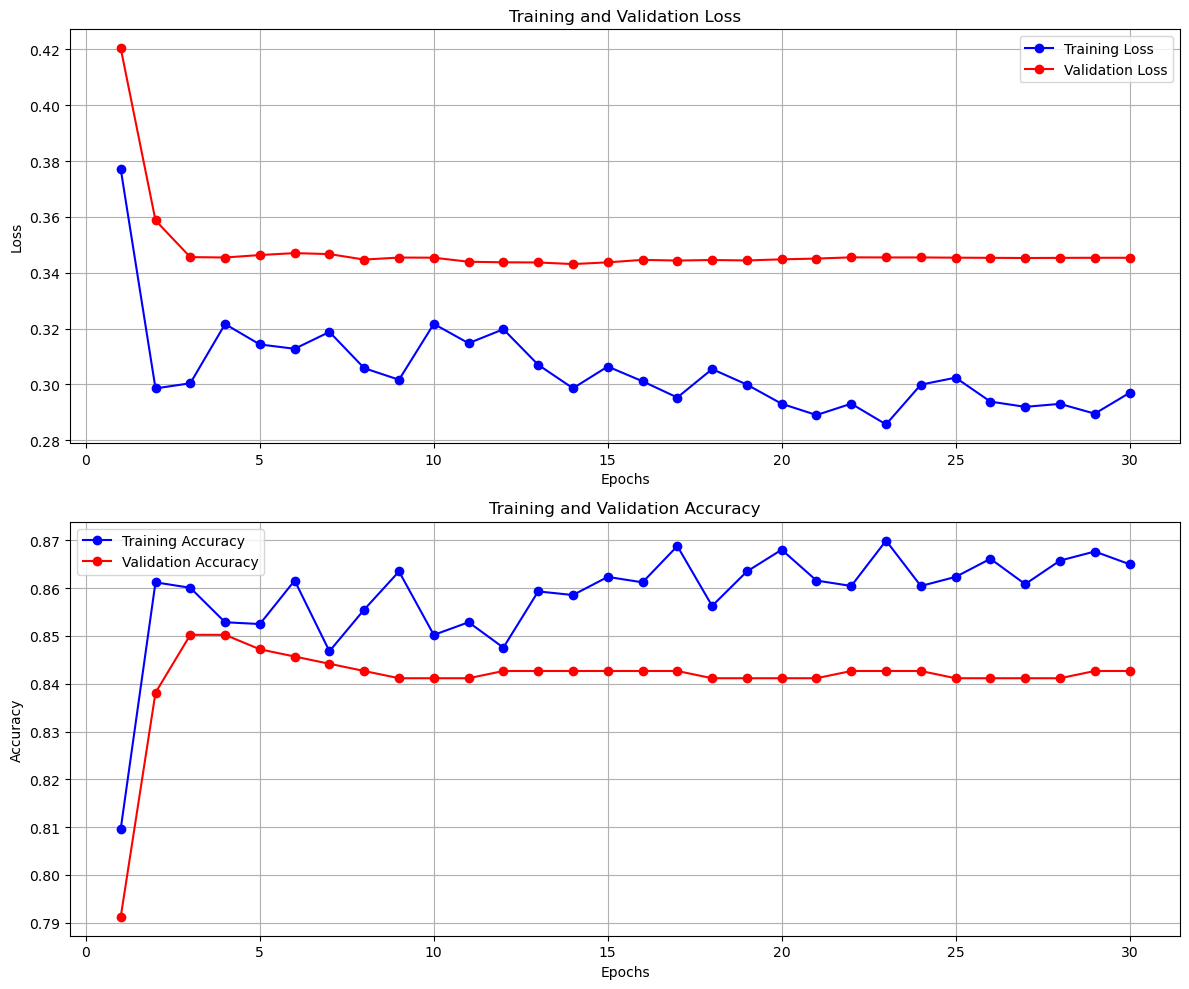

In [159]:
plot(hist_fine)

In [160]:
best_model = tf.keras.models.load_model(checkpoint_filepath)
print("Best model loaded successfully.")

Best model loaded successfully.


In [161]:
results = best_model.evaluate(ds_test, verbose=1)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

print("\nFine-tuning history keys:", hist_fine.history.keys())

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8664 - auc: 0.9412 - loss: 0.3038 - precision: 0.8664 - recall: 0.8664
Test Loss: 0.34559768438339233, Test Accuracy: 0.8502269387245178

Fine-tuning history keys: dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


# Test Accuracy 

In [162]:
from tensorflow.keras.models import load_model
model = load_model('best_fine_tuned_model.keras')

In [163]:
results = model.evaluate(ds_test, verbose=1)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]*100:.5f}%")

print("\nFine-tuning history keys:", hist_fine.history.keys())

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.8664 - auc: 0.9412 - loss: 0.3038 - precision: 0.8664 - recall: 0.8664
Test Loss: 0.34559768438339233, Test Accuracy: 85.02269%

Fine-tuning history keys: dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])
